# Загрузка данных, импортирование библиотек

Необходимо подготовить данные, для того чтобы их можно было использовать для обучения.

In [1]:
pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import matplotlib as plt
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


import catboost as cb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier


import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [5]:
from skopt import BayesSearchCV

In [6]:
data = pd.read_csv('train.csv.zip')

In [7]:
test_x = pd.read_csv('test.csv.zip')

In [8]:
data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


# Предварительный анализ данных

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [10]:
data.groupby('gluc')['cardio'].sum() / data.groupby('gluc')['cardio'].count()

gluc
1    0.480590
2    0.593064
3    0.622022
Name: cardio, dtype: float64

In [11]:
data.loc[((data['weight'] < 100) & (data['weight'] > 75)), 'cardio'].sum() / data.loc[((data['weight'] < 100) & (data['weight'] > 75)), 'cardio'].count()

0.5802083772725355

In [12]:
data.loc[((data['weight'] < 75) & (data['weight'] > 50)), 'cardio'].sum() / data.loc[((data['weight'] < 75) & (data['weight'] > 50)), 'cardio'].count()

0.43834397571443523

Если предположить что с повышением веса вероятность кардио проблем повышается то можно предположить что 1 - инсульт, 0 - здоровье.

Так же видно что чем выше глюкоза тем хуже.

In [13]:
data.groupby('alco')['cardio'].sum() / data.groupby('alco')['cardio'].count()

alco
0    0.500574
1    0.484325
Name: cardio, dtype: float64

Алкоголь как ни странно оказывает противоположное действие, там ноль хуже чем 1.

In [14]:
data.groupby('gender')['cardio'].sum() / data.groupby('gender')['cardio'].count()

gender
1    0.496727
2    0.505231
Name: cardio, dtype: float64

И курение аналогично, чем меньше тем хуже. И активность

А холестерин работает так же как сахар, с повышением вероятность инсульта выше.

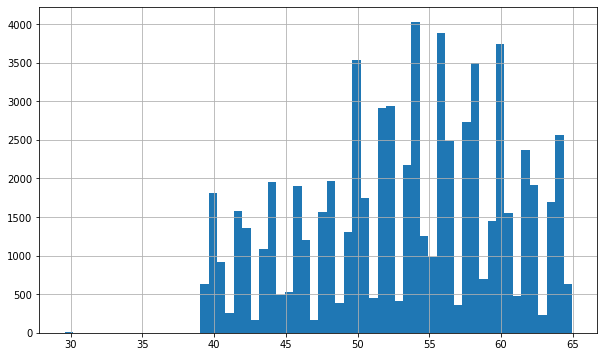

In [15]:
(data['age']/365).hist(bins=60, figsize = (10, 6))

Возраст в днях. С ним всё в порядке в доработках не нуждается.

In [16]:
m_1 = data['age'] > 6500
m_1.count() - m_1.sum()

0

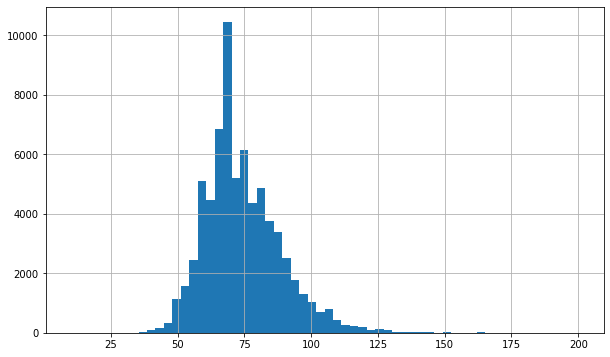

In [17]:
data.loc[:, 'weight'].hist(bins=60, figsize = (10, 6))

In [18]:
data['weight'].describe()  

count    70000.000000
mean        74.205690
std         14.395757
min         10.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        200.000000
Name: weight, dtype: float64

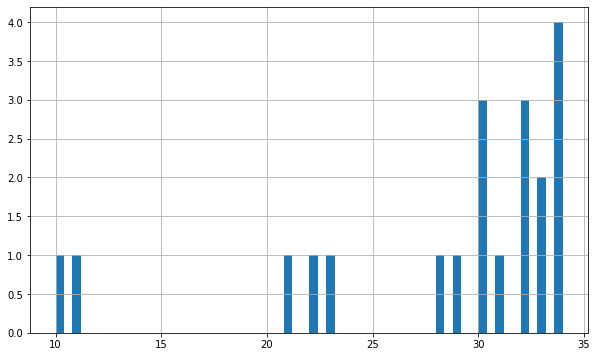

In [19]:
data.loc[data['weight']<35, 'weight'].hist(bins=60, figsize = (10, 6))

In [20]:
data[data['weight']<30]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
26806,38312,23284,1,157,23.0,110,80,1,1,0,0,1,0
29488,42156,20408,2,177,22.0,120,80,1,1,1,1,1,0
33817,48318,21582,2,178,11.0,130,90,1,1,0,0,1,1
34276,48976,14664,2,128,28.0,120,80,1,1,0,0,1,0
57858,82567,18804,2,165,10.0,180,1100,2,2,0,0,1,1
60188,85931,21855,1,162,21.0,120,80,2,1,0,0,1,1
60699,86650,18875,1,171,29.0,110,70,2,1,0,0,1,1


In [21]:
m_2 = data['weight'] > 29

m_2.count() - m_2.sum()

7

Удалил слишком худых людей Толстые пока выглядят правдоподобно

In [22]:
data.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [23]:
data['height'].describe()  

count    70000.000000
mean       164.359229
std          8.210126
min         55.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        250.000000
Name: height, dtype: float64

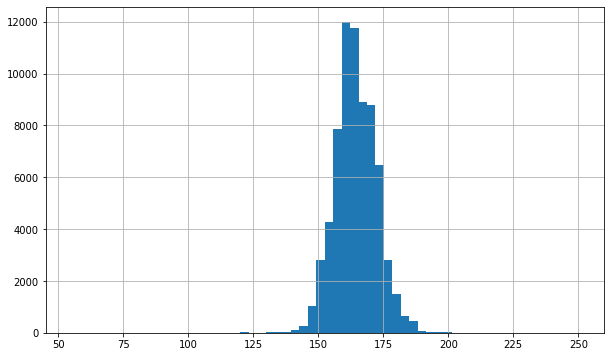

In [24]:
data['height'].hist(bins=60, figsize = (10, 6))

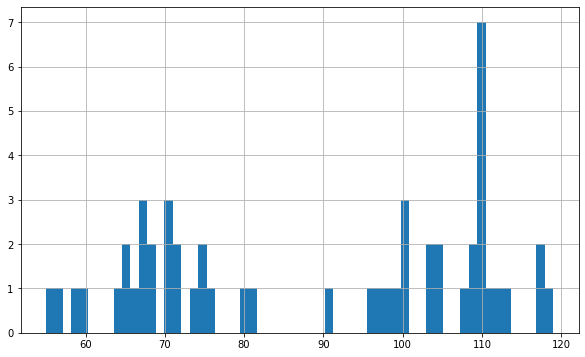

In [25]:
data.loc[data['height'] < 120, 'height'].hist(bins=60, figsize = (10, 6))

In [26]:
data[data['height'] < 60]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
22723,32456,23386,1,55,81.0,130,90,1,1,0,0,1,1
64115,91523,18426,1,59,57.6,125,67,1,1,0,0,0,0
66643,95141,18830,1,57,61.0,130,90,1,1,0,0,1,1


In [27]:
m_3 = (data['height'] < 210) & (data['height'] > 110)
m_3.count() - m_3.sum()

47

Для людей ниже 100 нужно добавить 100
Для людей ниже 110 и выше 210 удалил строки

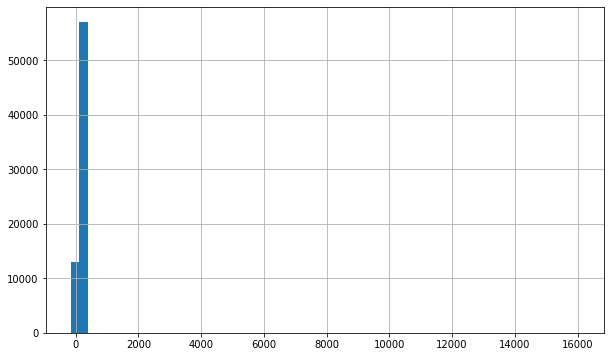

In [28]:
data['ap_hi'].hist(bins=60, figsize = (10, 6))

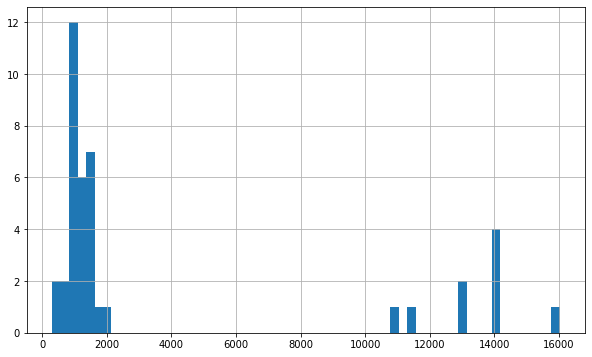

In [29]:
data.loc[(data['ap_hi'] > 300 ), 'ap_hi'].hist(bins=60, figsize = (10, 6))

In [30]:
m_4 = (data['ap_hi'] < 300 ) & (data['ap_hi'] > 30)
m_4.count() - m_4.sum()

228

Сменим знак для отрицательных значений. Добавим сто для значений ниже 50, разделим на 10 значения выше300. Остальное удалим.

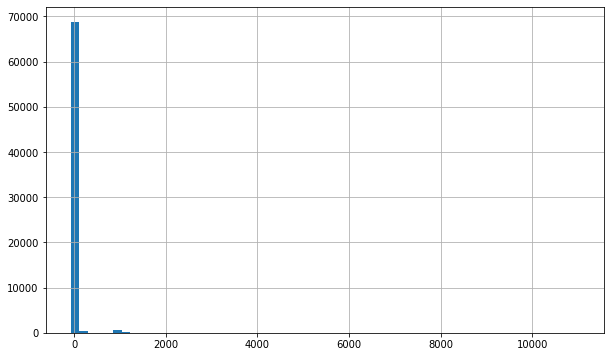

In [31]:
data['ap_lo'].hist(bins=60, figsize = (10, 6))

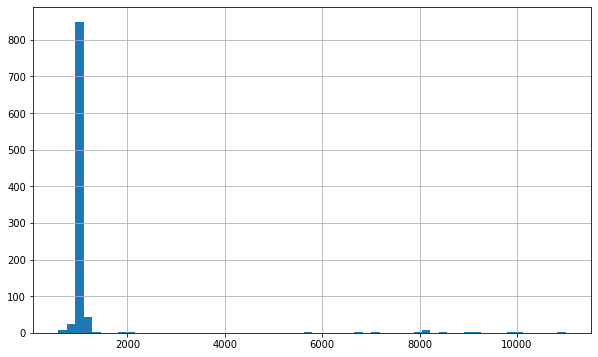

In [32]:
data.loc[data['ap_lo'] > 200, 'ap_lo'].hist(bins=60, figsize = (10, 6))

In [33]:
data.loc[data['ap_lo'] > 200, 'ap_lo'].median()

1000.0

In [34]:
m_5 = (data['ap_lo'] < 200 ) & (data['ap_lo'] > 20)
m_5.count() - m_5.sum()

1006

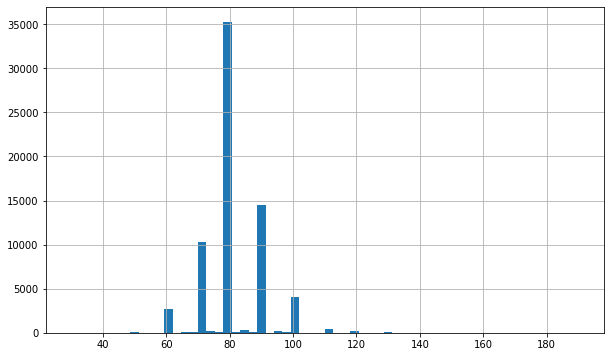

In [35]:
data.loc[m_5, 'ap_lo'].hist(bins=60, figsize = (10, 6))

Проделал аналогичный вещи с нижним давлением

In [36]:
m_6 = ((data['ap_hi'] - data['ap_lo']) < 120 ) & ((data['ap_hi'] - data['ap_lo']) > 10)

In [37]:
m_7 = ((data['weight'] / (data['height'] **2)) < .006) & ((data['weight'] / (data['height'] **2)) > .001)

In [38]:
mask = m_1 & m_2 & m_3 & m_4 & m_5 & m_6 & m_7

In [39]:
mask.count() - mask.sum()

1494

In [40]:
def discarding(df):
  mask = (
      (df['age'] > 6500) &
      (df['weight'] > 29) &
      ((df['height'] < 210) & (df['height'] > 110)) &
      ((df['ap_hi'] < 300 ) & (df['ap_hi'] > 30)) &
      ((df['ap_lo'] < 200 ) & (df['ap_lo'] > 20))&
      (((df['ap_hi'] - df['ap_lo']) < 120 ) & ((df['ap_hi'] - df['ap_lo']) > 10)) &
      (((df['weight'] / (df['height'] **2)) < .006) & ((df['weight'] / (df['height'] **2)) > .001))
  )
  print(mask.count() - mask.sum())
  return mask
# Функция для получения списка только корректных значений

In [41]:
def replacement(df):
  data = df.copy()
  data.loc[data['height'] < 99, 'height'] = data['height'] + 100
  data.loc[(data['ap_hi'] < 0), 'ap_hi'] = data['ap_hi'] * (-1)
  data.loc[(data['ap_hi'] < 50), 'ap_hi'] = data['ap_hi'] + 100
  data.loc[(data['ap_hi'] > 300), 'ap_hi'] = data['ap_hi'] / 10
  data.loc[(data['ap_lo'] < 0), 'ap_lo'] = data['ap_lo'] * (-1)
  data.loc[(data['ap_lo'] > 200), 'ap_lo'] = data['ap_lo'] / 10
  return data
# Функция для ручной замены некорректных значений согласно логике и интуиции

In [42]:
def new_fit(df):
  features = df.copy()
  features.loc[features['gender'] == 2, 'gender'] = 0
  features['delta'] = features['ap_hi'] - features['ap_lo']
  features['index_mass'] = features['weight'] / (features['height'] **2)
  features['bad_habits'] = features['smoke'] + features['alco'] + features['active'] + features['gender']
  features['age_q'] = features['age']**2
  features['delta_q'] = features['delta']**2
  features['ap_hi_q'] = features['ap_hi']**2
  features['weight_q'] = features['weight']**2
  features['index_mass_q'] = features['index_mass'] **2
  features['bad_habits_q'] = features['bad_habits']**2
  features['height_q'] = features['height']**2
  features['ap_lo_q'] = features['ap_lo']**2
  return features
# Функция для создания кучи новых фичей

# Подготовка данных

### Первый вариант

In [43]:
features_cb = replacement(data)
features_cb = new_fit(features_cb)
target_cb = features_cb['cardio']
features_cb = features_cb.drop(columns = ['cardio', 'id'])
features_train_cb, features_test_cb, target_train_cb, target_test_cb = train_test_split(features_cb, 
                                                                              target_cb, test_size=0.3, random_state=123)
#Вариант с заменой неправдоподобных и созданием новых фичей.
#Разделение на трейн и тест (или без него)

In [44]:
mask = discarding(data)

1494


### Второй  вариант

In [45]:
#mask = discarding(data)
#features_train_cb = new_fit(data)
#target_train_cb = data['cardio']
#features_train_cb = features_train_cb[mask].drop(columns = ['cardio', 'id'])
#target_train_cb = target_train_cb[mask]
#Вариант с отбрасыванием неправдоподобных и созданием новых фичей.
#Использование ВСЕХ данных.

### Третий  вариант

In [46]:
features_train_lg = data.drop(columns = ['cardio', 'id'])
target_train_lg = data['cardio']
# Данные без предобработки, создания новых фичей и замены/отбрасывания неправдоподобных

# Непосредственно обучение моделей

## Катбуст

In [47]:
params = {'depth': [3, 4, 6, 7, 8],
          'learning_rate' : [0.01, 0.02, 0.03],
         'l2_leaf_reg': [2, 3, 4, 5, 6, 7, 8, 9],
         'iterations': [600, 700, 800, 900, 1000],
         'bootstrap_type':['No']}
cb_c = cb.CatBoostClassifier(eval_metric="AUC", verbose=False, thread_count = -1, 
                             random_state = 123, early_stopping_rounds = 40)
cb_bayes = BayesSearchCV(cb_c, params, scoring="roc_auc", cv = 3, n_iter = 42)
cb_bayes.fit(features_train_cb, target_train_cb, eval_set=(features_test_cb, target_test_cb))
# С детектором переобучения

BayesSearchCV(cv=3,
              estimator=<catboost.core.CatBoostClassifier object at 0x7fc300c0a7d0>,
              n_iter=42, scoring='roc_auc',
              search_spaces={'bootstrap_type': ['No'], 'depth': [3, 4, 6, 7, 8],
                             'iterations': [600, 700, 800, 900, 1000],
                             'l2_leaf_reg': [2, 3, 4, 5, 6, 7, 8, 9],
                             'learning_rate': [0.01, 0.02, 0.03]})

In [48]:
cb_bayes.best_params_

OrderedDict([('bootstrap_type', 'No'),
             ('depth', 7),
             ('iterations', 600),
             ('l2_leaf_reg', 7),
             ('learning_rate', 0.02)])

In [49]:
cb_bayes.best_score_

0.8027780615889663

In [50]:
roc_auc_score(target_test_cb, cb_bayes.predict_proba(features_test_cb)[:,1])

0.8033177130391651

In [51]:
roc_auc_score(target_test_cb, cb_bayes.predict_proba(features_test_cb)[:,1])

0.8033177130391651

In [52]:
cb_mod = cb.CatBoostClassifier(eval_metric="AUC", verbose=1500, thread_count = -1, iterations = 700,
                               random_state = 123, l2_leaf_reg = 7, learning_rate = 0.02, depth= 6)
cb_mod.fit(features_train_cb, target_train_cb)

0:	total: 15.8ms	remaining: 11s
699:	total: 10.7s	remaining: 0us


In [53]:
roc_auc_score(target_test_cb, cb_mod.predict_proba(features_test_cb)[:,1])

0.8033440531869261

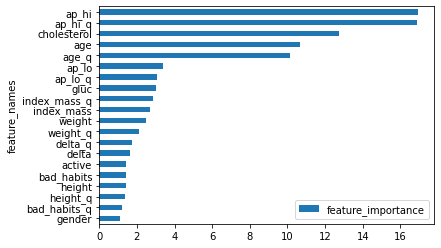

In [54]:
data = pd.DataFrame({'feature_importance': cb_mod.get_feature_importance(), 
              'feature_names': features_train_cb.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)
data[:20].sort_values(by=['feature_importance'], ascending=True).plot.barh(x='feature_names', y='feature_importance')

## LGBMClassifier

In [55]:
params = {'max_depth': [6, 7, 8, 10, 12, 15, 18, 20, 25, 30, 35],
          'learning_rate' : [0.01, 0.05, 0.08, 0.15],
         'lambda_l2': [0, 10, 15, 20, 30, 35, 40],
         'feature_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
          'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
         'cat_smooth': [1, 5, 10, 13, 15, 20, 35]}

lgb = LGBMClassifier(n_estimators=120, random_state = 123, verbose_eval = False)
lgb_bayes = BayesSearchCV(lgb, params, scoring="roc_auc", cv = 5, n_iter = 42)
lgb_bayes.fit(features_train_lg, target_train_lg)


BayesSearchCV(cv=5,
              estimator=LGBMClassifier(n_estimators=120, random_state=123,
                                       verbose_eval=False),
              n_iter=42, scoring='roc_auc',
              search_spaces={'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
                             'cat_smooth': [1, 5, 10, 13, 15, 20, 35],
                             'feature_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
                             'lambda_l2': [0, 10, 15, 20, 30, 35, 40],
                             'learning_rate': [0.01, 0.05, 0.08, 0.15],
                             'max_depth': [6, 7, 8, 10, 12, 15, 18, 20, 25, 30,
                                           35]})

In [56]:
lgb_bayes.best_params_

OrderedDict([('bagging_fraction', 0.9),
             ('cat_smooth', 15),
             ('feature_fraction', 0.8),
             ('lambda_l2', 15),
             ('learning_rate', 0.08),
             ('max_depth', 7)])

In [57]:
lgb_bayes.best_score_

0.8037426632107041

## RandomForestClassifier 

In [60]:
r_f_c = RandomForestClassifier(random_state = 123)
parametrs = { 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
              'criterion' : ['gini', 'entropy'],
              'n_estimators': [40, 60, 100, 140],
              'min_samples_leaf': [2, 3, 4, 5, 6, 7],
              'min_samples_split': [2, 3, 4, 5, 6, 7],
            }
grid_r_f_c = BayesSearchCV(r_f_c, parametrs, scoring = 'roc_auc', cv=5, n_iter = 42)
grid_r_f_c.fit(features_train_lg, target_train_lg,)

BayesSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
              n_iter=42, scoring='roc_auc',
              search_spaces={'criterion': ['gini', 'entropy'],
                             'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                             'min_samples_leaf': [2, 3, 4, 5, 6, 7],
                             'min_samples_split': [2, 3, 4, 5, 6, 7],
                             'n_estimators': [40, 60, 100, 140]})

In [61]:
grid_r_f_c.best_params_

OrderedDict([('criterion', 'entropy'),
             ('max_depth', 12),
             ('min_samples_leaf', 6),
             ('min_samples_split', 4),
             ('n_estimators', 100)])

In [62]:
grid_r_f_c.best_score_

0.8024831750218075

После обучения случайного леса ***roc_auc*** 

##  LogisticRegression

In [64]:
from sklearn.preprocessing import StandardScaler  

ss = StandardScaler()
X_train_scaled = ss.fit_transform(features_train_cb)
X_test_scaled = ss.transform(features_test_cb)
#y_train = np.array(y_train)


In [65]:
model_l_r = LogisticRegression(random_state = 25072022) #, class_weight = 'balanced')
parametrs = { 'C': [1, 2, 3, 4, 5],
              'penalty': ['l2', 'none'],
              'solver': ['lbfgs', 'sag'],
            }
grid_l_r = GridSearchCV(model_l_r, parametrs, scoring = 'roc_auc', cv=3)
grid_l_r.fit(X_train_scaled, target_train_cb)

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=25072022),
             param_grid={'C': [1, 2, 3, 4, 5], 'penalty': ['l2', 'none'],
                         'solver': ['lbfgs', 'sag']},
             scoring='roc_auc')

In [66]:
grid_l_r.best_params_

{'C': 1, 'penalty': 'none', 'solver': 'sag'}

In [67]:
grid_l_r.best_score_

0.7919825426593748

# Предсказания на валидации и выгрузка результатов

In [70]:
z = discarding(test_x)

641


In [73]:
features_cb_out = replacement(test_x)
features_cb_out = new_fit(features_cb_out)
features_cb_out = features_cb_out.drop(columns =  'id')
#Замена  по функции


In [74]:
features_lg_out = test_x.drop(columns =  'id')
#Вообще без замены

In [75]:
pred_cb = cb_bayes.predict_proba(features_cb_out)[:,1]
out_cb = pd.DataFrame(pred_cb, columns=['cardio'])
out_cb['id'] = test_x['id']
out_cb = out_cb.reindex(columns=['id', 'cardio'])
out_cb.to_csv('10_out_cb.csv', index=False)
# Предсказания и выгрузка результатов КАТБУСТ

In [76]:
pred_lg = lgb_bayes.predict_proba(features_lg_out)[:,1]
out_lg = pd.DataFrame(pred_lg, columns=['cardio'])
out_lg['id'] = test_x['id']
out_lg = out_lg.reindex(columns=['id', 'cardio'])
out_lg.to_csv('10_out_lg.csv', index=False)
# Предсказания и выгрузка результатов ЛГБТ

In [78]:
pred_rf = grid_r_f_c.predict_proba(features_lg_out)[:,1]
out_rf = pd.DataFrame(pred_rf, columns=['cardio'])
out_rf['id'] = test_x['id']
out_rf = out_rf.reindex(columns=['id', 'cardio'])
out_rf.to_csv('10_out_rf.csv', index=False)
# Предсказания и выгрузка результатов случайного леса

In [79]:
pred = (pred_cb + pred_lg + pred_rf) / 3
out = pd.DataFrame(pred, columns=['cardio'])
out['id'] = test_x['id']
out = out.reindex(columns=['id', 'cardio'])
out.to_csv('20_out_st.csv', index=False)
# Стекинг двух моделей и выгрузка результатов

Полные данные без обработки:
Катбуст - без валидации, лучший результат 0.80335, тестовый результат - 0.80816

ЛГБМ - без валидации, лучший результат 0.803398, тестовый результат - 0.80857

Блендинг, тестовый результат 0.80865

Полные данные с новыми фичами:

Катбуст - без валидации лучший вариант 0.80347, тестовый вариант - 0.80840

ЛГБМ - без валидации лучший вариант  0.80321, тестовый  0.80837

Блендинг, тестовый вариант 0.80865